In [1]:
#actin B

from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from __future__ import division
from showit import image, tile
import sys
from skimage.color import rgb2gray
sys.path.append("/Users/dganguli/src/starfish/")
from starfish.munge import list_to_stack

from starfish.spots.binary import BinarySpotDetector
from starfish.spots.gaussian import GaussianSpotDetector

base_path =  '/Users/dganguli/Downloads/ExampleInSituSequencing/'

def load_tiff_stack(path):
    stack = io.imread(path)
    stack = stack.astype(np.float32)
    stack = stack / 255
    return stack

def load_hyb_chan(hyb, chan):
    res = load_tiff_stack(base_path + '{}/c{}.tif'.format(hyb, chan))
    res = res.astype(np.float32)
    res = res / 255
    return res
    
hyb1 = [load_hyb_chan(1, c) for c in [2,3,4,5]]
hyb2 = [load_hyb_chan(2, c) for c in [2,3,4,5]]
hyb3 = [load_hyb_chan(3, c) for c in [2,3,4,5]]
hyb4 = [load_hyb_chan(4, c) for c in [2,3,4,5]]


stack = list_to_stack(hyb1+hyb2+hyb3+hyb4)
dapi = load_tiff_stack(base_path+'DO/c1.tif')
dots = load_tiff_stack(base_path+'DO/c2.tif')

## Raw Data

In [2]:
print stack.shape

(16, 980, 1330)


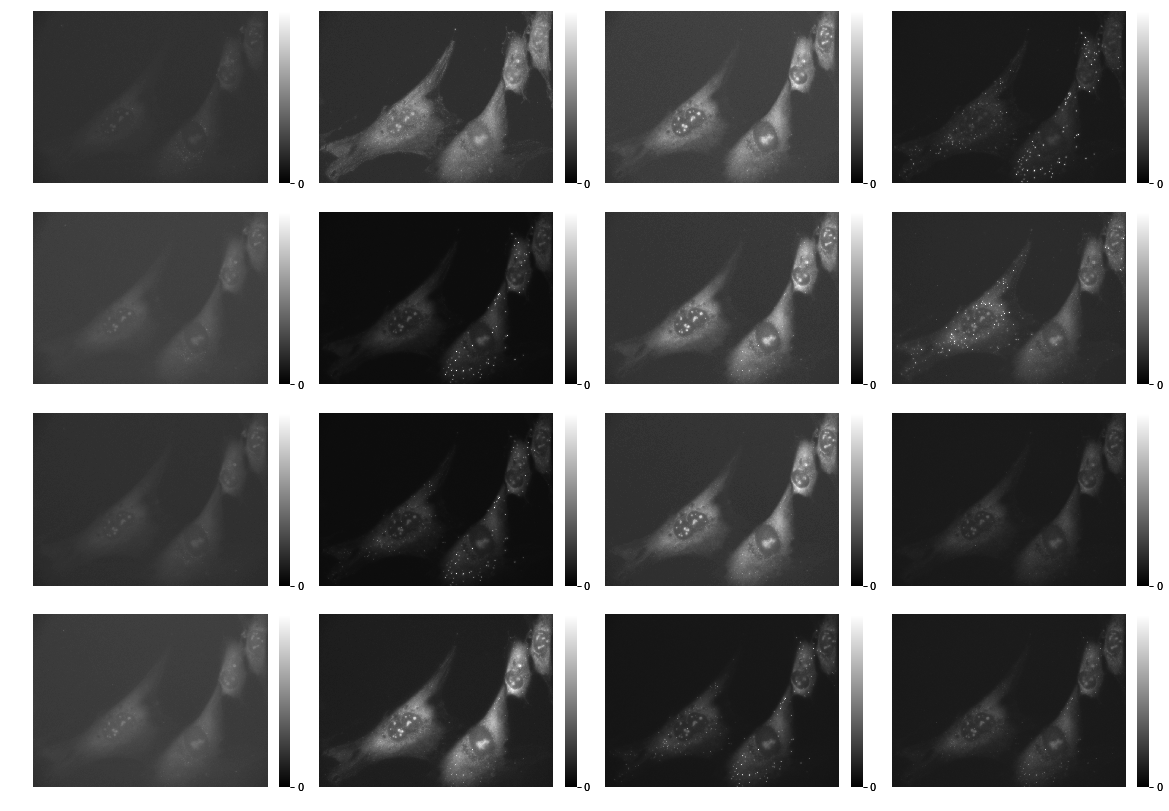

In [2]:
from starfish.viz import tile_lims
from starfish.munge import scale


tile(stack,bar=True,size=20);

## Filter

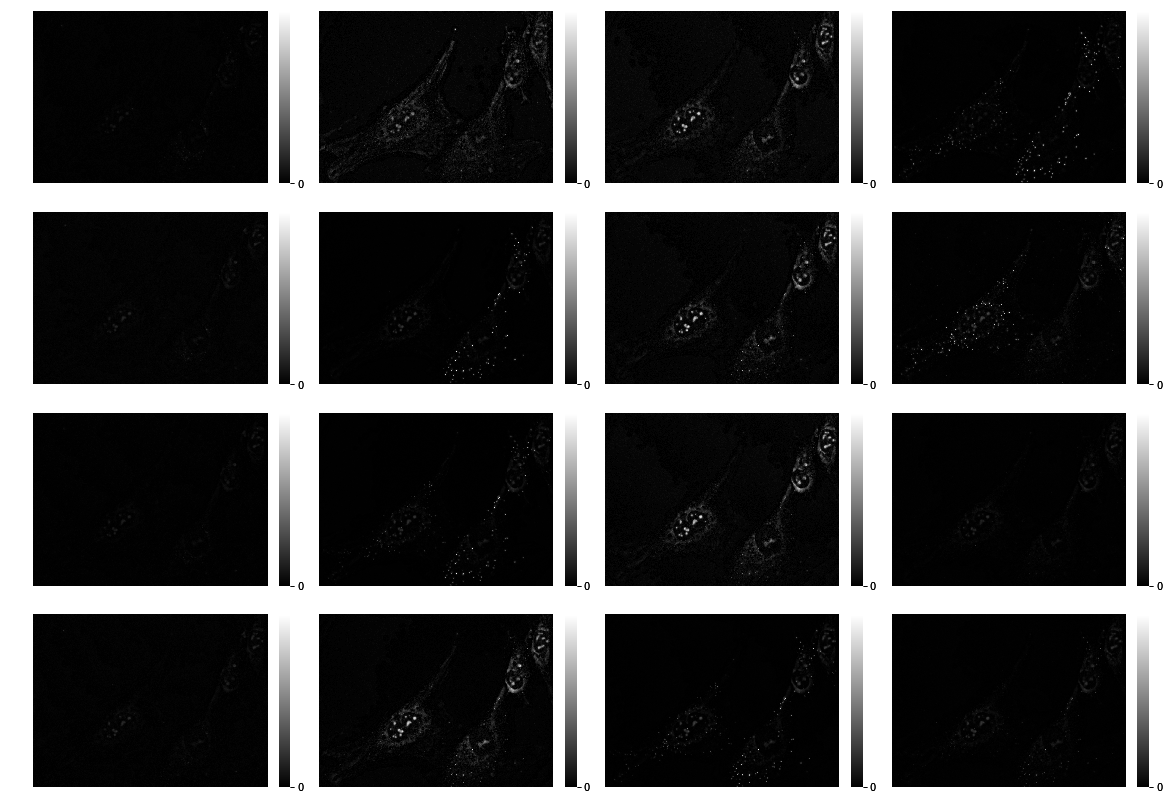

In [3]:
from starfish.filters import white_top_hat
from starfish.munge import stack_to_list

disk_dize = 15
stack_filt = [white_top_hat(s, disk_dize) for s in stack_to_list(stack)]
stack_filt = list_to_stack(stack_filt)
dots_filt = white_top_hat(dots, disk_dize)

tile(stack_filt, bar=True, size=20);

## Registration

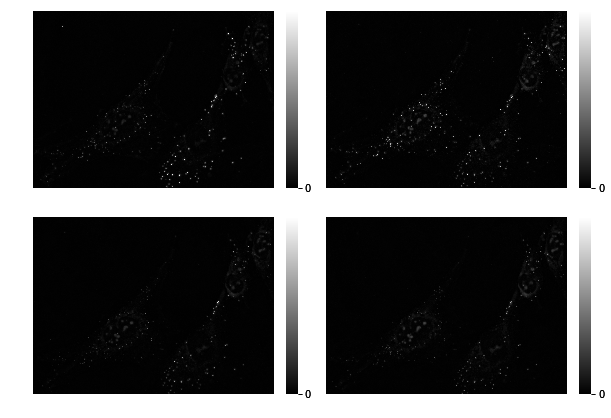

In [4]:
from starfish.munge import max_proj

# set up ability to project across channels for each hyb round
hybs = dict()
for j, k in enumerate([1,5,9,13]):
    res = np.array([i for i in range(k,k+4)])
    hybs[j] = res-1

max_projs = list_to_stack([max_proj(stack_filt[inds,:,:]) for hyb, inds in hybs.iteritems()])


tile(max_projs,bar=True,size=10);

For hyb: 0, Shift: [  3.123 -11.028], Error: 0.687817817583
For hyb: 1, Shift: [-1.74   2.832], Error: 0.820691077044
For hyb: 2, Shift: [ 4.988  0.423], Error: 0.695428911239
For hyb: 3, Shift: [ 6.067  0.812], Error: 0.797388491757


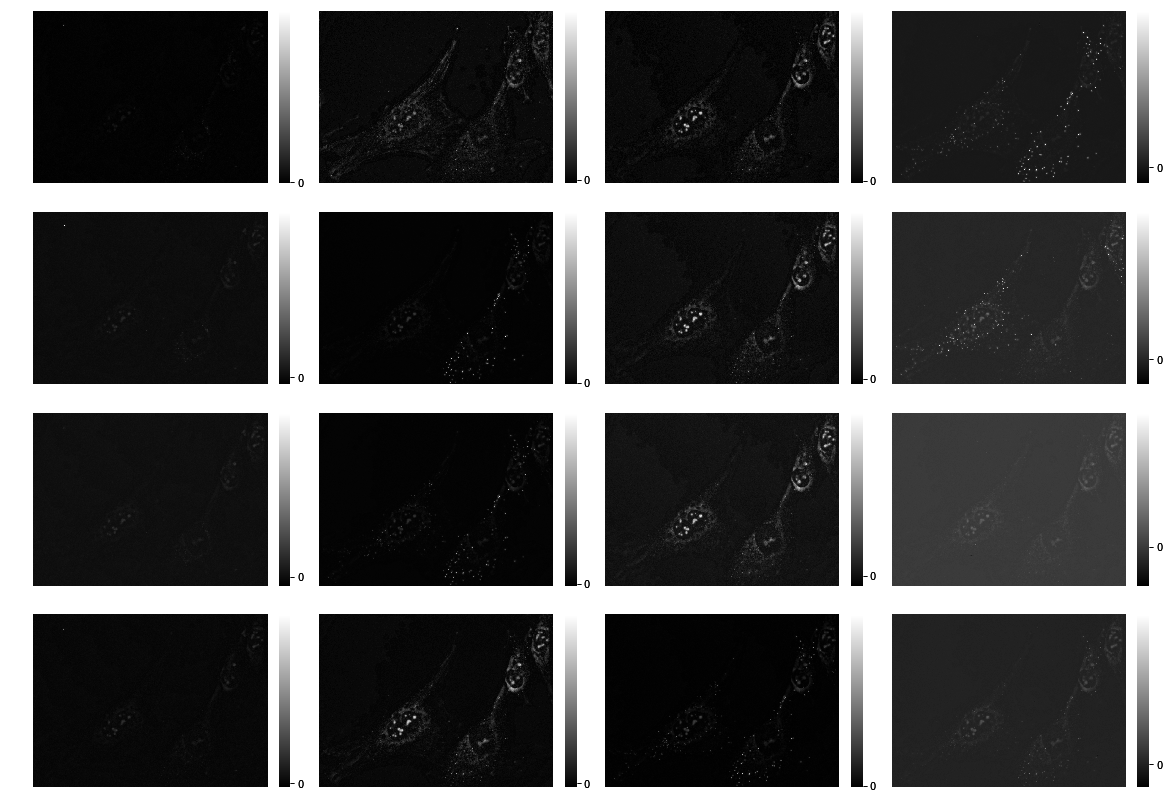

In [5]:
from starfish.register import register_stack, compute_shift, shift_im

upsample = 1000

stack_reg = np.zeros(stack_filt.shape)

# registers each hyb round (max projected across channels) to the general dot stain.
for k, inds in hybs.iteritems():
    shift, error = compute_shift(max_projs[k,:,:], dots_filt, upsample)
    print "For hyb: {}, Shift: {}, Error: {}".format(k, shift, error)
    for i in inds:
        stack_reg[i,:,:] = shift_im(stack_filt[i,:,:].astype(np.float32), shift)
    
tile(stack_reg,size=20,bar=True);

## Spot detection

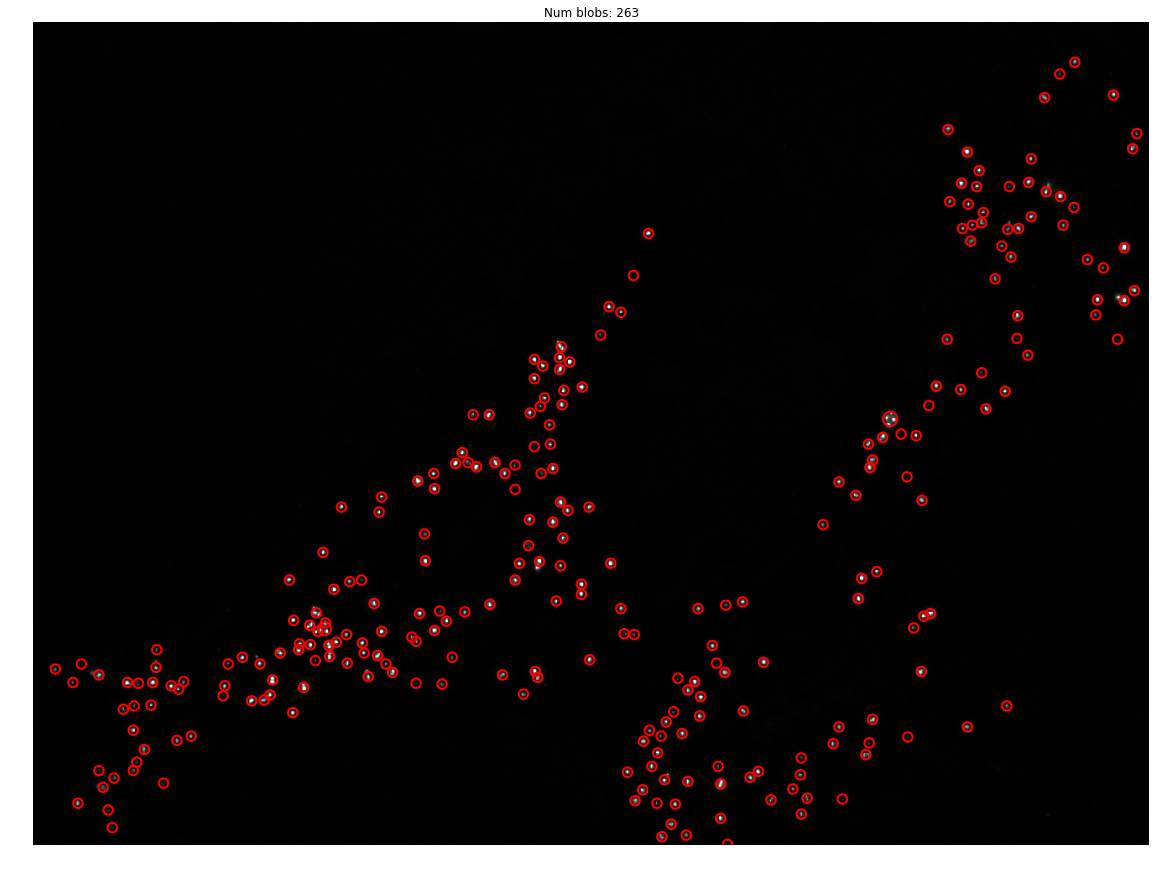

,spot_id,hybs,vals
0,0,hyb_1,0.000055
1,1,hyb_1,0.000153
2,2,hyb_1,0.000104
3,3,hyb_1,0.000047
4,4,hyb_1,0.000124


In [6]:
from starfish.spots.gaussian import GaussianSpotDetector

s = GaussianSpotDetector(stack_reg, dots_filt)
min_sigma = 4
max_sigma = 6
num_sigma=20
thresh=.01

s.detect(min_sigma,max_sigma,num_sigma, thresh)
s.show()
    
spots_viz = s.spots_df_viz
spots_df = s.to_encoder_dataframe(tidy_flag=False)
spots_df_tidy = s.to_encoder_dataframe(tidy_flag=True)
spots_df_tidy.head()

##  Segmentation

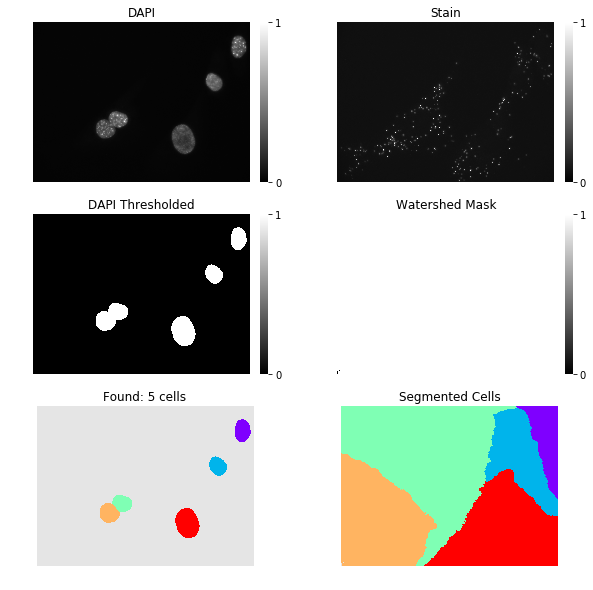

In [7]:
from starfish.filters import gaussian_low_pass
from starfish.watershedsegmenter import WatershedSegmenter

 
seg = WatershedSegmenter(dapi, dots)
cells_labels = seg.segment(dapi_thresh, stain_thresh, size_lim, disk_size_markers, disk_size_mask, min_dist)
seg.show()

## Assignment

In [8]:
from starfish.assign import assign

points = spots_viz.loc[:, ['x', 'y']].values
ass = assign(cells_labels, points, use_hull=True)
ass.groupby('cell_id',as_index=False).count().rename(columns={'spot_id':'num spots'})

,cell_id,num spots
0,0,19
1,1,28
2,2,56
3,3,85
4,4,74


## Decode

In [9]:
def decode(spots_df_tidy):
    spots_df_tidy.loc[:, 'ch'] = None
    spots_df_tidy.loc[:, 'hyb'] = None
    
    for k in [1, 2, 3, 4]:
        cols = ['hyb_{}'.format(j) for j in [k, k + 4, k + 8, k + 12]]
        ind = spots_df_tidy.hybs.isin(cols)
        spots_df_tidy.loc[ind, 'ch'] = k

    for j, k in enumerate([1, 5, 9, 13]):
        cols = ['hyb_{}'.format(i) for i in range(k, k + 4)]
        ind = spots_df_tidy.hybs.isin(cols)
        spots_df_tidy.loc[ind, 'hyb'] = j + 1

    del spots_df_tidy['hybs']

    num_ch = 4
    num_hy = 4
    num_spots = spots_df_tidy.spot_id.max()

    seq_res = np.zeros((num_spots, num_hy))
    seq_stren = np.zeros((num_spots, num_hy))
    seq_qual = np.zeros((num_spots, num_hy))

    for sid in range(1, num_spots + 1):

        sid_df = spots_df_tidy[spots_df_tidy.spot_id == sid]

        mat = np.zeros((num_hy, num_ch))
        inds = zip(sid_df.hyb.values - 1, sid_df.ch.values - 1, sid_df.vals)

        for tup in inds:
            mat[tup[0], tup[1]] = tup[2]

        max_stren = np.max(mat, axis=1)
        max_ind = np.argmax(mat, axis=1)
        qual = max_stren / np.sum(mat, axis=1)

        seq_res[sid - 1, :] = max_ind
        seq_stren[sid - 1, :] = max_stren
        seq_qual[sid - 1, :] = qual

    max_qual = np.max(seq_qual, axis=1)

    letters = ['T', 'G', 'C', 'A']

    codes = []
    for k in range(seq_res.shape[0]):
        letter_inds = seq_res[k, :]
        letter_inds = letter_inds.astype(np.int)
        res = ''.join([letters[j] for j in letter_inds])
        codes.append(res)

    dec = pd.DataFrame({'spot_id': range(1, num_spots + 1),
                        'gene': codes,
                        'qual': max_qual})

    return dec

dec = decode(spots_df_tidy)

AAGC    159
AGGC     98
TATT      1
AAAC      1
GGGG      1
Name: gene, dtype: int64

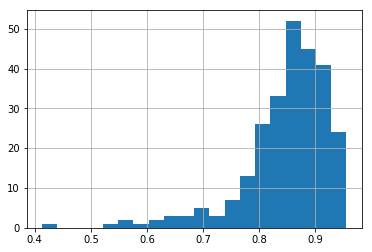

In [10]:
dec.qual.hist(bins=20)

top_gene = dec.gene.value_counts()[0:5]
top_gene

## Visualization

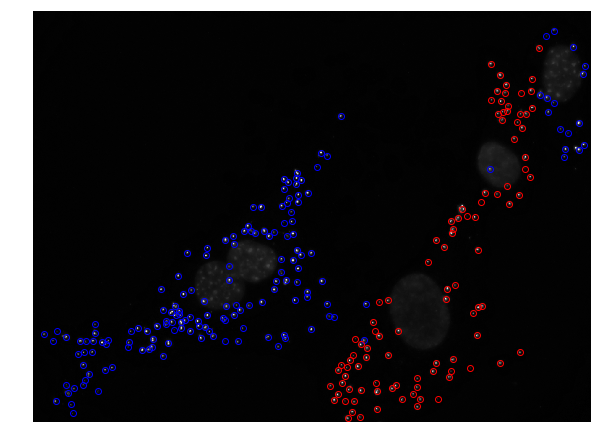

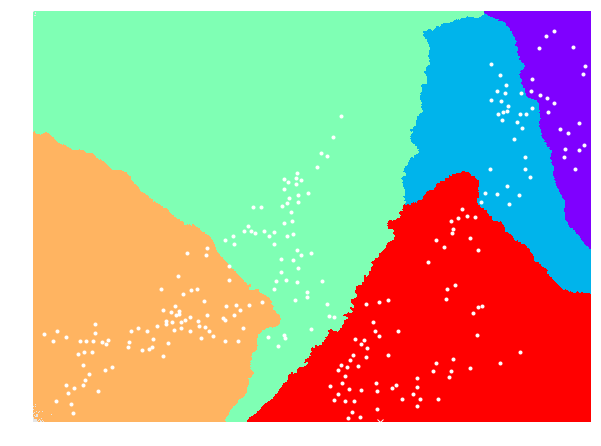

In [11]:
from starfish.stats import label_to_regions
from skimage.color import rgb2gray

dec_filt = pd.merge(dec, spots_viz, on='spot_id',how='left')
dec_filt = dec_filt[dec_filt.qual>.25]

rgb = np.zeros((980, 1330,3))
rgb[:,:,0] = dapi
rgb[:,:,1] = dots_filt
do = rgb2gray(rgb)
do = do/(do.max())

image(do,size=10)
plt.plot(dec_filt[dec_filt.gene==top_gene.index[0]].y, dec_filt[dec_filt.gene==top_gene.index[0]].x, 'ob', markerfacecolor='None')
plt.plot(dec_filt[dec_filt.gene==top_gene.index[1]].y, dec_filt[dec_filt.gene==top_gene.index[1]].x, 'or', markerfacecolor='None')

v = pd.merge(spots_viz, ass, on='spot_id')

r = label_to_regions(cells_labels)
im = r.mask(background=[0.9, 0.9, 0.9], dims=dots.shape, stroke=None, cmap='rainbow')
image(im,size=10)

v_ass = v[~v.cell_id.isnull()]
plt.plot(v_ass.y, v_ass.x, '.w')

v_uass = v[v.cell_id.isnull()]
plt.plot(v_uass.y, v_uass.x, 'xw')

## Cell by gene expression table

In [35]:
res = pd.merge(dec, ass, on='spot_id', how='left')
grp = res.groupby(['gene', 'cell_id'],as_index=False).count()
exp_tab = grp.pivot(index='cell_id', columns='gene', values = 'spot_id').fillna(0)
exp_tab


gene,AAAC,AAAT,AAGC,AAGG,AGGC,GGGG,TATT
cell_id,,,,,,,
0,1.0,0.0,16.0,0.0,2.0,0.0,0.0
1,0.0,0.0,1.0,0.0,27.0,0.0,0.0
2,0.0,1.0,54.0,0.0,0.0,0.0,1.0
3,0.0,0.0,84.0,1.0,0.0,0.0,0.0
4,0.0,0.0,4.0,0.0,69.0,1.0,0.0


In [38]:
res.head()

,gene,qual,spot_id,cell_id
0,AGGC,0.860275,1,4
1,AGGC,0.891429,2,4
2,AAGC,0.777064,3,3
3,AGGC,0.869374,4,4
4,AGGC,0.853653,5,4


In [39]:
spots_viz.head()

,x,y,r,d,xmin,xmax,ymin,ymax,intensity,spot_id
0,979.0,827.0,5.656854,11.313708,973.0,985.0,821.0,833.0,0.050980,0
1,970.0,749.0,5.656854,11.313708,964.0,976.0,743.0,755.0,0.615686,1
2,968.0,778.0,5.656854,11.313708,962.0,974.0,772.0,784.0,0.498039,2
3,959.0,94.0,5.656854,11.313708,953.0,965.0,88.0,100.0,0.156863,3
4,955.0,760.0,5.656854,11.313708,949.0,961.0,754.0,766.0,0.682353,4


## Make spots.json and cells.json for visualization

In [88]:
import json
import scipy.misc

def make_spot_dict(row):
    row = row[1]
    d = dict()
    d['properties'] = {'id':int(row.spot_id), 'radius': int(row.r)}
    d['geometry'] = {'type':'Point', 'coordinates': [int(row.x), int(row.y)]}
    return d

def make_cell_dict(id, verts):
    d = dict()
    d["properties"] = {"id":id}
    d["geometry"] = {"type":"Polygon", 
                     "coordinates": list(map(lambda x: list(x), verts.astype(int)))
                    }
    return d

spots_json = [make_spot_dict(row) for row in spots_viz.iterrows()]
cell_json = [make_cell_dict(id, verts) for id, verts in enumerate(r.hull)]


with open('/Users/dganguli/Desktop/spots.json', 'wb') as outfile:
    json.dump(spots_json, outfile)

with open('/Users/dganguli/Desktop/regions.json', 'wb') as outfile:
    json.dump(cell_json, outfile)

scipy.misc.imsave('/Users/dganguli/Desktop/data.png', do)   